<a href="https://colab.research.google.com/github/ammarisme/export-forecast-NR/blob/master/HS_code_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install pycountry
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import pycountry
import difflib

from os import path

In [32]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/rubber"
DATASET_TYPE = "test"
TARGET_DIR = "cleaned"
SOURCE_DIR = "raw/4001"

Mounted at /content/drive


Get unique metric units from raw files.

In [33]:
def get_units(source_directory):
  units  = []
  print(source_directory)
  for directory in os.listdir(source_directory):
    for filename in os.listdir(source_directory+'/'+directory):
      try:
        file_data = pd.read_html(source_directory+'/'+directory+'/'+filename)
        #print('success: ', filename)
        first_line =file_data[0][0][0]
        data_records = file_data[1]
        for column in data_records.columns:
          if "Unit" in data_records[column].unique():
            my_units = data_records[column].unique()
            my_units = filter(lambda unit: str(unit).startswith("20") == False, my_units)
            units.extend(my_units)
            units = list(set(units))
      except:
        print(directory+'/'+filename)
  return units

unique_units = get_units(PATH+'/input_mix/'+DATASET_TYPE+'/raw')
unique_units = [x for x in unique_units if str(x) != 'nan']
print(unique_units)

/content/drive/My Drive/rubber/input_mix/test/raw
['Gross', 'Kilograms air dried', 'Units', 'Kilograms', 'paire', 'Meters', 'Pair', 'Dozens pairs', 'Pairs', 'No Quantity', 'Unit', 'Pounds', 'kilogrammes', 'Square meters', 'Dozens', 'Tons', 'Mixed', 'Heads']


Assign weigth convertion ratios from different metrics to kilograms.

In [0]:
unit_weights =dict()
for unit in unique_units:
  unit_weights[unit]=0

unit_weights['Pair'] = 0.1
unit_weights['Dozens pairs'] = 0
unit_weights['Pounds'] = 0.453592
unit_weights['Mixed'] = 0
unit_weights['Square meters'] = 1522
unit_weights['Gross'] = 1
unit_weights['Kilograms'] = 1
unit_weights['No Quantity'] = 0
unit_weights['Pairs'] = 0
unit_weights['Pounds'] = 0.453592
unit_weights['Units'] = 0
unit_weights['Kilograms air dried'] = 1
unit_weights['Heads'] = 0
unit_weights['kilogrammes'] = 1

unit_weights['Tons'] = 1000
unit_weights['Pounds'] = 0.453592
unit_weights['Unit'] = 0
unit_weights['Heads'] = 0
unit_weights['kilogrammes'] = 1
unit_weights['Dozens'] = 0
unit_weights['Meters'] = 0
unit_weights['paire'] = 0

In [0]:
import pycountry
import difflib

def clean_directory_1(source_directory, target_directory,  hs=None):
  final_data_records = pd.DataFrame({
      'country': []
  })
  
  all_countries = list()
  for filename in os.listdir(source_directory):
    file_data = pd.read_html(source_directory+'/'+filename)
    data_records = file_data[1]
    countries = data_records[0][2:]

    for country in countries:
      if country not in all_countries:
        all_countries.append(country)

  for country in all_countries:
    if country not in final_data_records['country']:
      temp_df = pd.DataFrame({
          'country' : [country]
      })
      final_data_records = final_data_records.append(temp_df)
    
  for filename in os.listdir(source_directory):
    print('cleanining: ',filename)
    file_data = pd.read_html(source_directory+'/'+filename)
    first_line =file_data[0][0][0]
    my_country=""
    for country in pycountry.countries:
        if country.name in first_line:
            my_country = country.name
    second_line = file_data[0][0][1]
    hs_code = second_line.split()[1]
    if hs != None and hs != hs_code:
      print('skipping :', hs_code)
      continue

    
    file_records = pd.DataFrame()
    data_records = file_data[1]
    data_records = data_records.fillna(0)
    for unit_weight_key in unit_weights:
          data_records = data_records.replace(to_replace =unit_weight_key, 
                 value =unit_weights[unit_weight_key]) 
    
    for country in all_countries:    
      country_records = data_records[data_records[0]==country]
      if len(country_records) == 0:
        continue
      #update the dataframe. add the columns
      for column in data_records.columns:
        
        prev_column_name = data_records[column][:1][0]#last column name
        if column == 0:
          continue
        if column == 1:
          #first column will be added anyway. if this is a double column, will be replaced in the next step.
          final_data_records.loc[final_data_records['country']==country, prev_column_name] = int(country_records[column].values[0])
          continue

        if len(data_records.columns) > column+1:
          current_column_name = data_records[column+1][:1][0]#current column name
          if current_column_name == prev_column_name:
            final_data_records.loc[final_data_records['country']==country, current_column_name] = int(country_records[column+1].values[0]) * int(country_records[column].values[0])
          else:
            final_data_records.loc[final_data_records['country']==country, current_column_name] = int(country_records[column+1].values[0])

  sorted_columns = [final_data_records.columns[0]]
  sorted_columns.extend(sorted(final_data_records.columns[1:]))
  final_data_records = final_data_records[sorted_columns]

  final_data_records =  final_data_records.fillna(0)

  #final_data_records.to_csv(target_directory+'/'+hs_code+'-'+my_country+'_pca_cleaned.csv', index=False)
#clean_directory_1(source_directory+'4004', PATH+'/input_mix/'+DATASET_TYPE+'/'+TARGET_DIR)

Check for duplicate columns in cleaned hs-code files.

In [0]:
def country_duplicate_check():
  close_matches =   [difflib.get_close_matches(country, all_countries) for country in all_countries]
  #test against duplicate entries
  for match in close_matches:
    print(match)

Using above functions, traverse all the hs-code directories in **source_directory** and compile a cleaned file per *hs_code*

In [37]:
source_directory = PATH+'/input_mix/'+DATASET_TYPE+'/raw/'
target_directory = PATH+'/input_mix/'+DATASET_TYPE+'/'+TARGET_DIR
"""
for directory in os.listdir(source_directory):
  try:
    if directory == "4001":
      clean_directory_1(source_directory+'/'+directory, target_directory)
  except:
    print('error:',directory)
"""

'\nfor directory in os.listdir(source_directory):\n  try:\n    if directory == "4001":\n      clean_directory_1(source_directory+\'/\'+directory, target_directory)\n  except:\n    print(\'error:\',directory)\n'

Start combining all cleaned hs-code files into one.
step 1: get all countries and months and prepare the dataframe to fit the whole dataset

In [0]:
def accumulate_all_hs_code_files():
  #accumulate all the countries and months of available data
  countries = []
  months = []
  hs_codes = []
  for cleaned_filename in os.listdir(target_directory+'/hs-code-files/'):
    try:
      cleaned_file = pd.read_csv(target_directory+'/hs-code-files/'+cleaned_filename)
      
      hs_code = cleaned_filename.split('-')[0]
      hs_codes.append(hs_code)
      #print(hs_code)
      if hs_code == "4001":
        #print(cleaned_file)
        c = cleaned_file[cleaned_file['country']=='China'].values[:].tolist()[0][1:]
        plt.plot(c)
        #break
      #else:
        #continue

      countries_temp = cleaned_file['country'].unique()
      countries_temp = [country for country in countries_temp if country!="World"] 
      countries.extend(countries_temp)

      months_temp = cleaned_file.columns
      months_temp = [month for month in months_temp if month!="country"] 
      months.extend(months_temp)
    except:
      print('error:',cleaned_filename)

  months = list(set(months))
  countries = list(set(countries))

  #add a country entry per each hs code
  my_countries = []
  for code in hs_codes:
    my_countries.extend([country+'_'+code for country in countries])
  countries = my_countries
  print(countries)
  df_columns = ['month']
  df_columns.extend(countries)
  processed_data = pd.DataFrame(columns=df_columns)

  processed_data['month'] = sorted(months)

  sorted_columns = [processed_data.columns[0]]
  sorted_columns.extend(sorted(processed_data.columns[1:]))
  processed_data = processed_data[sorted_columns]
  print('number of months :',len(processed_data))
  print('number of columns (countries+hscodes) :',len(processed_data.columns))
  return processed_data

Combine all the hs-code files into one **cleaned/all-hs-codes-combined.csv**

In [0]:
#accumulate all the countries and months of available data
def convert_to_monthly_data():
  for cleaned_filename in os.listdir(target_directory+'/hs-code-files'):
    #try:
    hs_code = cleaned_filename.split('-')[0]
    print('hs code processing : ', hs_code)
    print(target_directory+'/hs-code-files'+cleaned_filename)
    cleaned_file = pd.read_csv(target_directory+'/hs-code-files/'+cleaned_filename)
    countries_temp = cleaned_file['country']
    update_countries = [country+'_'+hs_code for country in countries_temp if country!="World"] 
    months = cleaned_file.columns
    #else:
    #  continue
    for month in cleaned_file.columns:
      #print(month)
      if month == "country":
        continue
      processed_data.loc[processed_data['month']==month,update_countries] = cleaned_file.loc[:, cleaned_file.columns == month ].to_numpy().squeeze().tolist()
    
  processed_data = processed_data.fillna(0)

  return processed_data
  #processed_data.to_csv(target_directory+'/all_hs_codes_combined.csv')


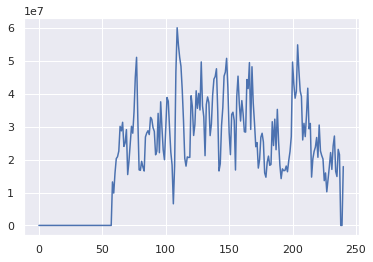

In [40]:
processed_data['China_4001'].plot()

In [0]:
#target variable creation
def create_target_variable(processed_data):
  target = np.zeros(len(processed_data))
  for column in processed_data.columns:
    if "4001" in column or "4003" in column:
      target += processed_data[column]

  processed_data['target'] = target
  print(processed_data['target'])
  processed_data['target'].plot()

  processed_data = create_target_variable(processed_data)
  
  return processed_data
processed_data.to_csv(target_directory+'/all_hs_codes_combined.csv', index=False)

PCA

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def normalize(processed_data):

  return processed_data
def pca_extract(processed_data):
  features = [ column for column in processed_data.columns if column != "month"]

  # Separating out the features
  x = processed_data.loc[:, features].values
  y = processed_data.loc[:,['target']].values

  x = StandardScaler().fit_transform(x)
  y = StandardScaler().fit_transform(y)
  
  pca = PCA(n_components=12)

  principalComponents = pca.fit_transform(x)
  principal_columns = ['pc '+str(1+i) for i in range(12)]
  principalDf = pd.DataFrame(data = principalComponents
              , columns =principal_columns )
  principalDf['target'] = y
  final_columns = ['target']
  final_columns.extend([col for col in principalDf.columns if col != 'target' ])
  principalDf = principalDf[final_columns]
  return principalDf

principalDf = pca_extract(processed_data)
print(target_directory+'/pca_hs_codes_12.csv')
principalDf.to_csv(target_directory+'/pca_hs_codes_12.csv', index=False)

/content/drive/My Drive/rubber/input_mix/test/cleaned/pca_hs_codes_12.csv


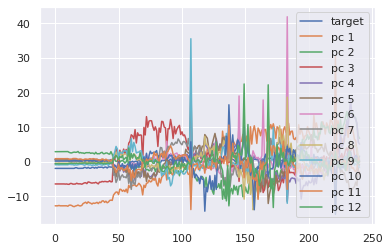

In [52]:
principalDf[principalDf.columns].plot()